## This notebook is for implementing a prediction method for hotel bookings.
The implementation takes notes from:
1. Webb, T., Schwartz, Z., Xiang, Z. and Singal, M., 2020. Revenue management forecasting: the resiliency of advanced booking methods given dynamic booking windows. International Journal of Hospitality Management, 89, p.102590.
2. Zhang, Y., 2019. Forecasting hotel demand using machine learning approaches (Doctoral dissertation, Cornell University).

The data is originally from Antonio, N., de Almeida, A. and Nunes, L., 2019. Hotel booking demand datasets. Data in brief, 22, pp.41-49.   
More detailed explanation for the variables can be seen there.


In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb



### Quick data exploration

In [2]:
data = pd.read_csv("../Data/hotel_bookings.csv")
data.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


In [4]:
data['hotel'].value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

## Take only the relevant data for our use case.  
We take all the reservations, expect the ones that were canceled.
Then we'll only take the date with leadtimes <180, to reduce complexity of the models.   
We will also be only focusing on "City Hotel" as there are more observations for it.

In [5]:
df = data.query('is_canceled == 0 and hotel == "City Hotel"')[['lead_time','arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month']]
df["date"] = pd.to_datetime(df['arrival_date_day_of_month'].astype(str) +'-'+ df['arrival_date_month'].astype(str)+'-'+ df['arrival_date_year'].astype(str),infer_datetime_format=True)
df = df[['lead_time','date']]
df = df.groupby(['date','lead_time',]).size().reset_index().pivot(index="date", columns="lead_time").fillna(0)
df=df.droplevel(0, axis=1).iloc[:, ::-1].cumsum(axis=1).iloc[:, ::-1].reset_index().iloc[:,:182]
df = df.rename(columns={col: 'ROH_'+str(col) 
                        for col in df.columns if col not in ['date']})
df['weekday'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month_name()
df['year'] = df['date'].dt.year
df['ROH_LAG_1'] = df['ROH_0'].shift(1)
df['ROH_LAG_7'] = df['ROH_0'].shift(7)
df['ROH_LAG_14'] = df['ROH_0'].shift(14)
df = df.dropna()
df

lead_time,date,ROH_0,ROH_1,ROH_2,ROH_3,ROH_4,ROH_5,ROH_6,ROH_7,ROH_8,...,ROH_177,ROH_178,ROH_179,ROH_180,weekday,month,year,ROH_LAG_1,ROH_LAG_7,ROH_LAG_14
14,2015-07-18,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,0.0,0.0,0.0,0.0,Saturday,July,2015,55.0,1.0,65.0
15,2015-07-20,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,Monday,July,2015,43.0,2.0,1.0
16,2015-07-22,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,...,0.0,0.0,0.0,0.0,Wednesday,July,2015,2.0,31.0,10.0
17,2015-07-23,39.0,39.0,39.0,39.0,39.0,39.0,39.0,39.0,39.0,...,0.0,0.0,0.0,0.0,Thursday,July,2015,24.0,1.0,9.0
18,2015-07-24,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Friday,July,2015,39.0,24.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,2017-08-27,79.0,72.0,65.0,65.0,64.0,64.0,64.0,62.0,62.0,...,17.0,16.0,16.0,16.0,Sunday,August,2017,63.0,78.0,53.0
784,2017-08-28,106.0,103.0,103.0,103.0,102.0,101.0,101.0,100.0,100.0,...,80.0,80.0,80.0,80.0,Monday,August,2017,79.0,63.0,66.0
785,2017-08-29,60.0,54.0,52.0,52.0,52.0,52.0,50.0,49.0,49.0,...,19.0,18.0,17.0,17.0,Tuesday,August,2017,106.0,41.0,66.0
786,2017-08-30,34.0,33.0,33.0,33.0,33.0,32.0,32.0,32.0,31.0,...,10.0,10.0,10.0,10.0,Wednesday,August,2017,60.0,60.0,62.0


## Now we have the data as we want it

<AxesSubplot:xlabel='date', ylabel='ROH_0'>

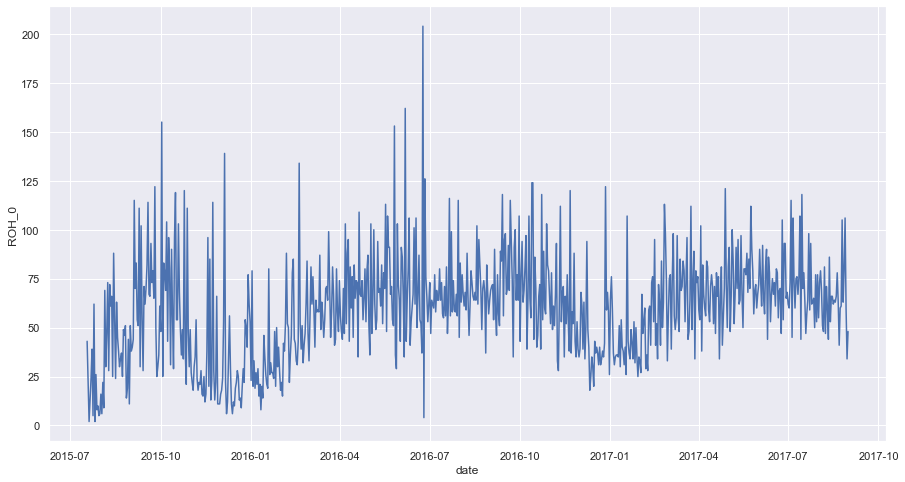

In [6]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=df,x='date',y='ROH_0')

There is some seasonality visible in the time series. There is also a lot of noise, and the model results can be unsatisfying.

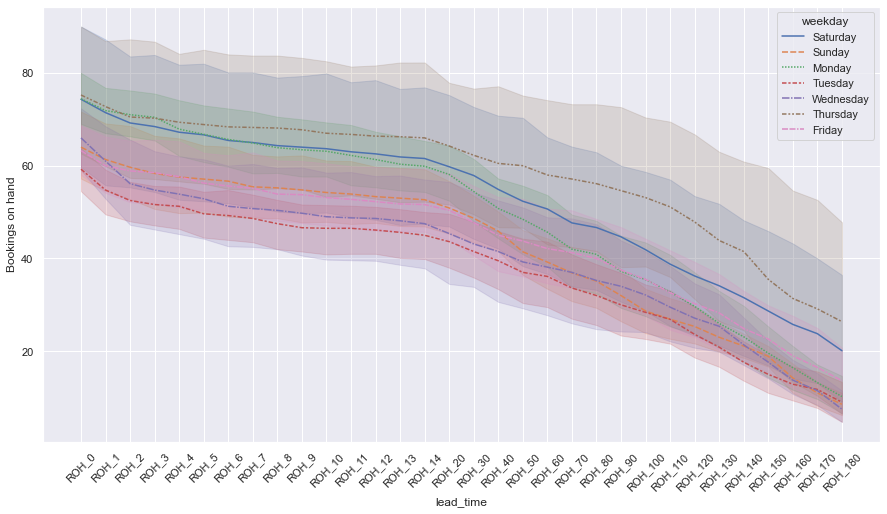

In [7]:
sns.set(rc = {'figure.figsize':(15,8)})
example_booking_curve = df[(df['date']>'2016-07-01') & (df['date']<'2016-08-30')].drop(columns=['date','month','year'])
# example_booking_curve
example_booking_curve=example_booking_curve.T
example_booking_curve.columns = example_booking_curve.iloc[181,:]
sns.lineplot(data=example_booking_curve[0:15].append(example_booking_curve[20::10]))
plt.ylabel('Bookings on hand')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);


There is a significant difference in the booking curves between weekdays, but even within them.   
This could imply that the weekday feature could be important for the model.

## Next we'll implement the prediction model

The model is an XGBoost model, with the booking curves, and the date information as the features.   
The target will be the final revervation count for each day.   

XGBoost is chosen due to its simple usage, but also because we want to be able to compute observations with missing values.   
Missing value will be in the data, as we are predicting with booking curves, where we cannot know the future Reservations on Hand (ROH).   
For our training data, we will simulate the missing values by setting random observations (reservation dates) to have the last 0-7 ROH's NaN.   
    - This is how the real data would flow into the hotel managers, as the reservations are made before the final date.

In [8]:
# n_lead_time_max = 182
# # Data for training.
# df_modeling = df.iloc[:,np.r_[:n_lead_time_max, -3:0]].query('date < "2017-01-01"')
# # Data for testing/validation
# df_test_ts = df.iloc[:,np.r_[:n_lead_time_max, -3:0]].drop(df_modeling.index)

# Data for training.
df_modeling = df.query('date < "2017-01-01"')
# Data for testing/validation
df_test_ts = df.drop(df_modeling.index)

Simulate real data with NaN values, and preprocess for modeling

In [9]:
df_frac = df_modeling.sample(frac = 0.6) # Fraction of the data will have missing values
rest_part = df_modeling.drop(df_frac.index)

def fill_ROH_na(row,days_ahead = 7):
    """Function for filling some curves with nan values.
    This is done to give the model a learning opportunity to be able to predict future values given missing ROH values.
    We will only fill ROH_1-ROH_7 with missing values, as we want to be able to predict 7 days into the future"""
    fill_until = np.random.randint(low=3,high=days_ahead+2)
    row[2:fill_until] = np.nan
    return row

df_frac = df_frac.apply(fill_ROH_na,axis=1)
df_sampled = pd.concat([df_frac, rest_part], ignore_index=True)

y = df_sampled.pop("ROH_0")
X = df_sampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# preprocessor doesn't work with new indices, need to reset all. WHY? 
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

train_dates = X_train.pop('date')
test_dates = X_test.pop('date')
cat_idx = [X_train.columns.get_loc(c) for c in ['weekday','month','year'] if c in X_train]
num_idx = [x for x in range(len(X_train.columns)) if x not in cat_idx]

# OneHot-encode the categorical date information
preprocessor_categorical = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_idx)
    ],
    remainder='passthrough'
)

X_train = preprocessor_categorical.fit_transform(X_train)# NO DATA LEAKS!
X_test = preprocessor_categorical.transform(X_test)

# For XGBoost
DTrain = xgb.DMatrix(X_train,label=y_train,feature_names=preprocessor_categorical.get_feature_names())
Dtest = xgb.DMatrix(X_test, label=y_test,feature_names=preprocessor_categorical.get_feature_names())


## Prediction algorithm

- Take the test data   
- Set current date 31.12.2016
- Take the next n days (rows)
- Set the unknown future values to nan, depending on the current date -> if 1.2.2017: set ROH_1 to nan, 2.2 set ROH_1 & ROH_2 to nan...
- Predict the n rows
- Set current date to n days into the future and repeat the process

In [10]:
def iter_validation(df,model,preprocessor,days_ahead = 7,plot_=True,aggr = 'daily'):

    preds = np.array([],dtype='float32')
    dates = np.array([],dtype='datetime64')
    current_date = df['date'].min()-pd.Timedelta(days=1)

    while current_date <= df["date"].max():

        # Take the next n days
        end_date = current_date+pd.Timedelta(days=days_ahead)
        t = df.query('date > @current_date and date <= @end_date').reset_index(drop=True)

        if t.empty:
            break

        t_dates = t.pop("date")
        y = t.pop("ROH_0")

        # Set nan values for values that we should not be able to know when the date is the current date.
        j = 0
        for i in t.index:
            t.iloc[i, 0:j] = np.nan
            j+=1


        X = preprocessor.transform(t)
        DTest_ts = xgb.DMatrix(X,label=y,feature_names = preprocessor.get_feature_names())
        curr_pred = model.predict(DTest_ts)

        preds = np.append(preds,curr_pred)
        dates = np.append(dates,t_dates)
        current_date = end_date

    real_values = df[['date','ROH_0']].set_index('date')
    predictions = pd.DataFrame(preds,dates).rename(columns = {0:'prediction'})
    res =real_values.join(predictions)

    if aggr == 'weekly':
        res = res.reset_index().groupby([pd.Grouper(key='date', freq='W-MON',label='left')]).sum().reset_index()

    # Print and plot results
    print("MAPE: %f" % (mean_absolute_percentage_error(res["ROH_0"],res['prediction'])))
    print("RMSE: %f" % mean_squared_error(res["ROH_0"],res['prediction'],squared=True))
    print("MAE: %f" % mean_absolute_error(res["ROH_0"],res['prediction']))
    if plot_:
        sns.set(rc = {'figure.figsize':(25,10)})
        sns.lineplot(data=res)
    return res


Hyperparameter optimization using GridSearchCV.

In [214]:
param_grid = {
            'booster':['gbtree'],
            'objective':['reg:squarederror'],
            'max_depth': [4,6,8,10],
            'alpha': [1,5,10],
            'lambda':[0,3,5],
            'learning_rate': [0.5]
        }     
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model, param_grid, n_jobs=5, 
                   cv=4, 
                   scoring='neg_mean_absolute_percentage_error',#   neg_root_mean_squared_error
                   verbose=2, refit=True)

clf.fit(X_train, y_train);
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').iloc[:4,3:].T

Fitting 4 folds for each of 36 candidates, totalling 144 fits


,24,13,15,14
std_score_time,0.0005,0.000435,0.0006,0.001787
param_alpha,10,5,5,5
param_booster,gbtree,gbtree,gbtree,gbtree
param_lambda,0,0,0,0
param_learning_rate,0.5,0.5,0.5,0.5
param_max_depth,4,6,10,8
param_objective,reg:squarederror,reg:squarederror,reg:squarederror,reg:squarederror
params,"{'alpha': 10, 'booster': 'gbtree', 'lambda': 0...","{'alpha': 5, 'booster': 'gbtree', 'lambda': 0,...","{'alpha': 5, 'booster': 'gbtree', 'lambda': 0,...","{'alpha': 5, 'booster': 'gbtree', 'lambda': 0,..."
split0_test_score,-0.13265,-0.131414,-0.12852,-0.129476
split1_test_score,-0.157273,-0.152869,-0.135674,-0.14413


In [11]:
# best_params = clf.best_params_

# Current best parameters
best_params = {'alpha': 10,
'booster': 'gbtree',
'lambda': 0,
'learning_rate': 0.5,
'max_depth': 4,
'objective': 'reg:squarederror'}


MAPE: 0.097506
RMSE: 55.989620
MAE: 5.919418


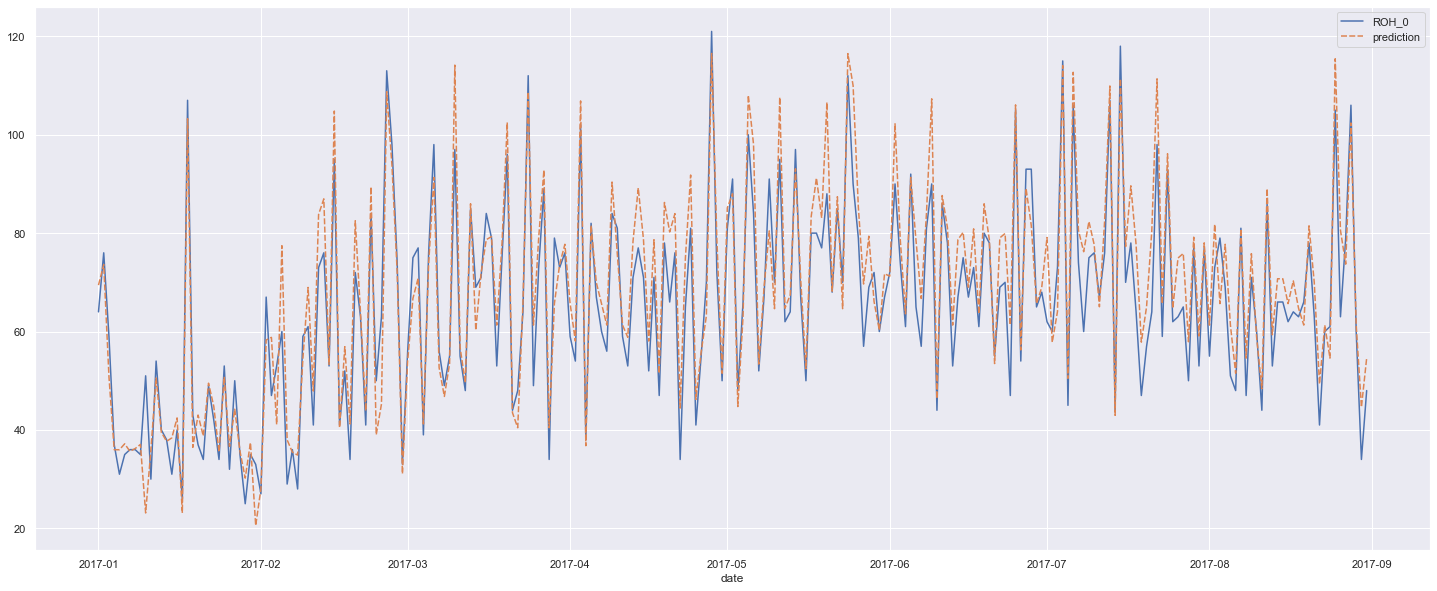

In [12]:
xg_current_best=xgb.train(params=best_params, dtrain=DTrain, num_boost_round=10)
res = iter_validation(df_test_ts,preprocessor=preprocessor_categorical,days_ahead=7,model=xg_current_best)

Above figure shows how our model performs with new unseen data.   
The predictions are made as previously explained, one week at a time. Thus, this figure represents how well our model predicts the next week's daily reservations.

- Mean Absolute Percentage Error (MAPE) is approximately 8%.
    - This error tells us on average, how large the absolute errors are compared to the real values.
    - 8% MAPE means that on average, the prediction ($F_t$) deviates from the actual value ($A_t$) by $\pm$ 8%
- Root Mean Squared Error (RMSE) is approximately 42.
    - This error tells us that on average the absolute error is 42 reservations.
    - This metric is computed as:  $\sqrt{\frac{1}{n}\Sigma_{t=1}^{n}{\Big(A_t -F_t\Big)^2}}$
    - This metric is more sensitive to outliers than MAE.
- Mean absolute error (MAE) is approximately 5.
    - This error tells us that on average the absolute error is 5 reservations.

Our selected error metrics show that the prediction is ok. The performance could be better, as can be seen from RMSE.   
The model cant find all the sudden peaks or falls on the daily reservations.   
However, as we do not want to overfit, this kind of performance could be accurate enough for real world usage.

Feature importances show us how important the model deems the features. After wrangling around with the data and trying out different feature subset,   
I've concluded that it is best to keep all the features even though their importance is not great.   
This is because the model (XGBoost) is fast enough for this number of features, and fewer features resulted in worse accuracy.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

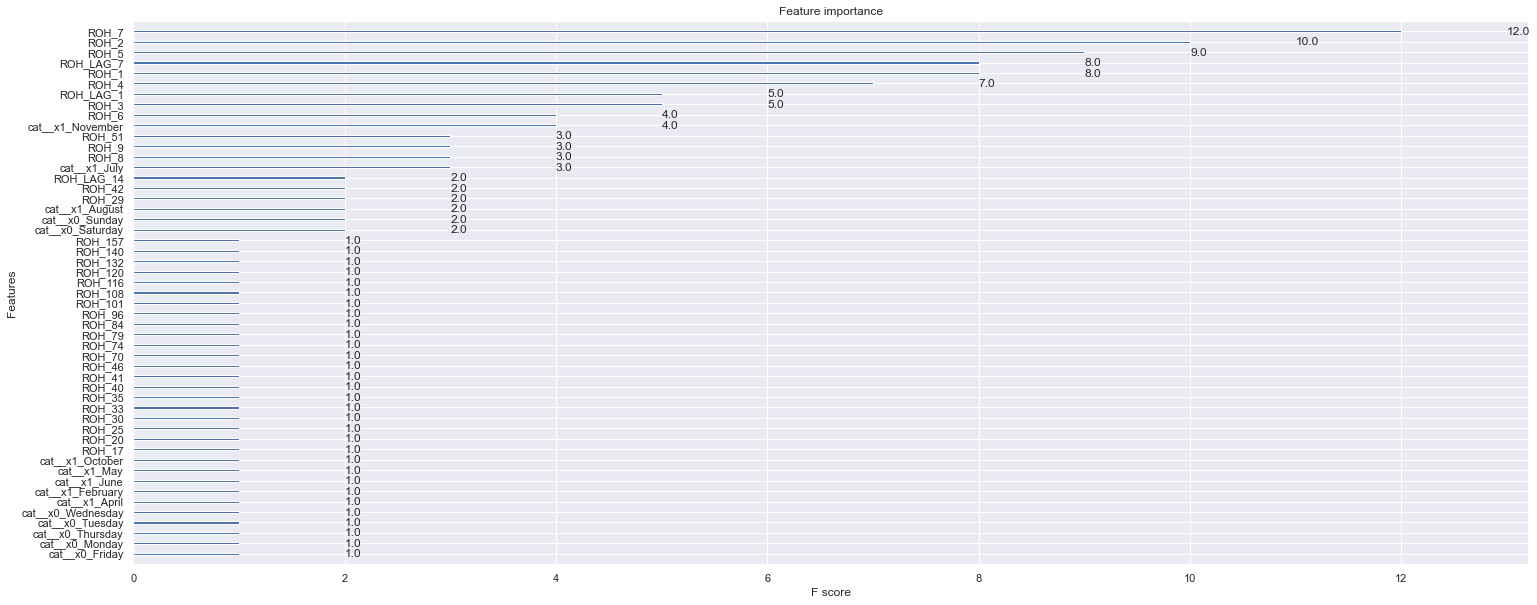

In [13]:
xgb.plot_importance(xg_current_best)
# xgb.plot_tree(xg_current_best)

MAPE: 0.097506
RMSE: 55.989620
MAE: 5.919418


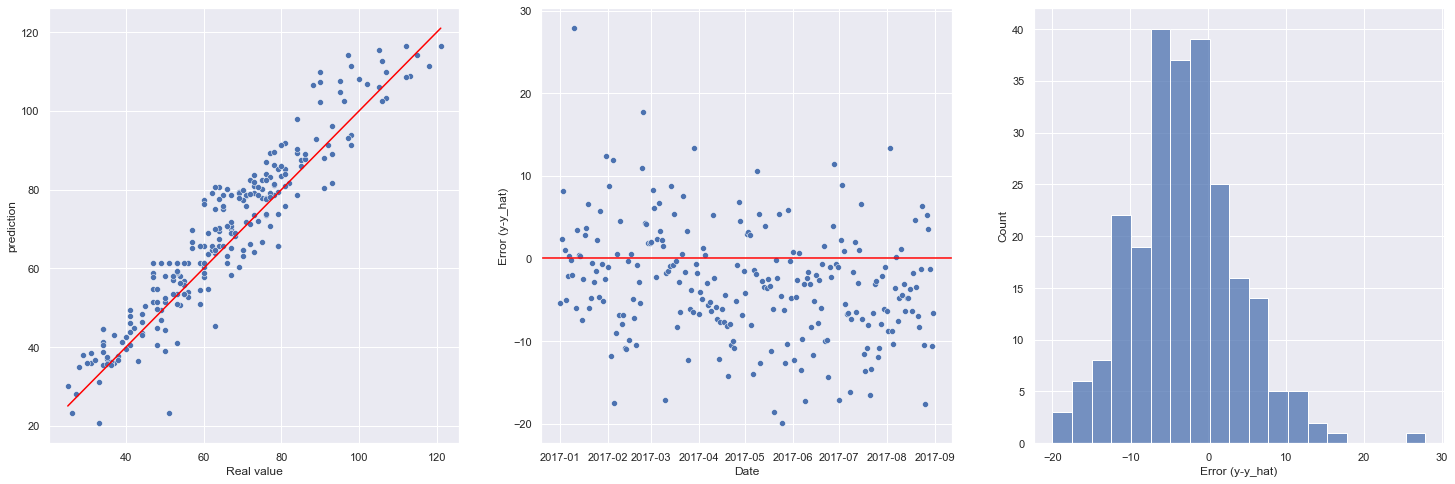

In [14]:
def plot_diagnostics(res):
    """[date real pred;]"""

    print("MAPE: %f" % (mean_absolute_percentage_error(res["ROH_0"],res['prediction'])))
    print("RMSE: %f" % mean_squared_error(res["ROH_0"],res['prediction'],squared=True))
    print("MAE: %f" % mean_absolute_error(res["ROH_0"],res['prediction']))

    sns.set(rc = {'figure.figsize':(25,8)})
    fig, ax = plt.subplots(ncols=3)
    sns.scatterplot(data=res,x='ROH_0',y='prediction',ax=ax[0])
    sns.lineplot(x=[res['ROH_0'].min(),res['ROH_0'].max()],
                    y = [res['ROH_0'].min(),res['ROH_0'].max()],color='red',ax=ax[0])
    ax[0].set_xlabel('Real value');

    sns.scatterplot(x=res.index,y=res['ROH_0']-res['prediction'],ax=ax[1])
    ax[1].axhline(0,c='red')
    ax[1].set_xlabel('Date');
    ax[1].set_ylabel('Error (y-y_hat)');

    sns.histplot(res['ROH_0']-res['prediction'],ax=ax[2])
    ax[2].set_ylabel('Count');
    ax[2].set_xlabel('Error (y-y_hat)');

plot_diagnostics(res)

The diagnostic plots above show how the predictions compare to the actual values.   
The figure on the right, shows how the predictions are quite close to the actual values.

The figure on the left shows the errors for each predicted date. From this figure, we can see that there seems to be a slight constant bias on the predicted values.   
The predictions are on average larger than the actual values. This could be due to multiple reasons, but the MAE is still only approximately 5 reservations per day.

## Weekly aggregation results
Here we take a look at the results, when daily predictions and actual values from before are aggregated to a weekly frequency.   

MAPE: 0.056758
RMSE: 959.249171
MAE: 25.006465


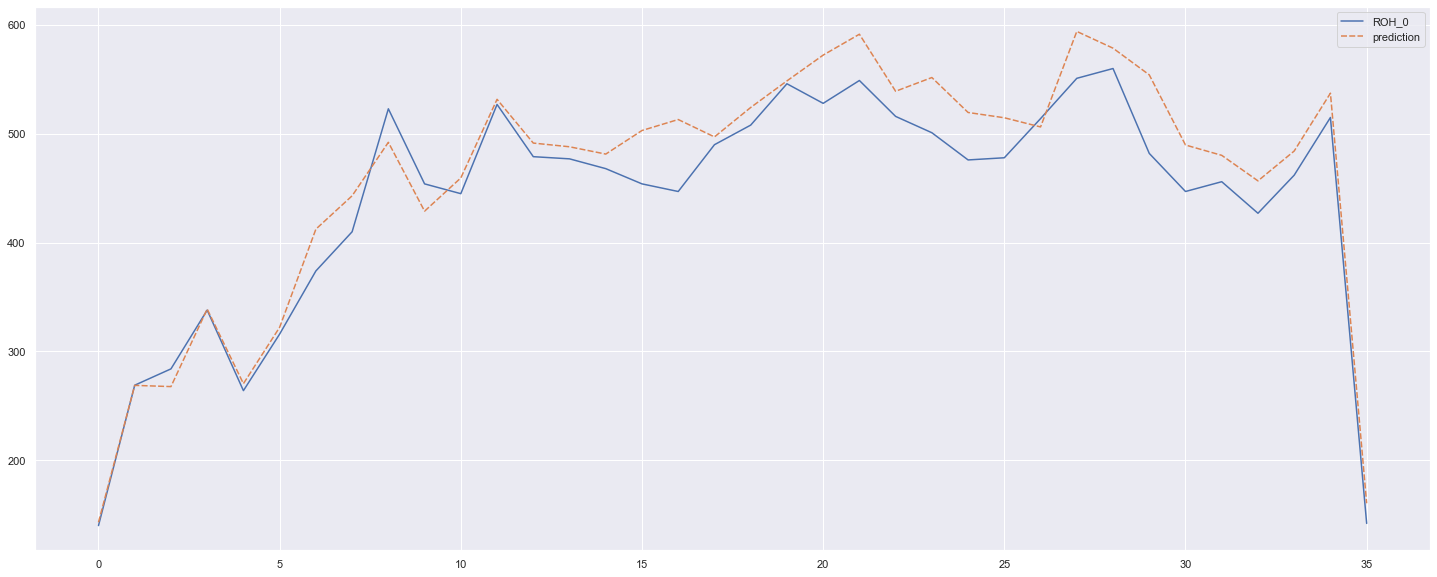

In [15]:
res_weekly = iter_validation(df_test_ts,preprocessor=preprocessor_categorical,days_ahead=7,model=xg_current_best,aggr='weekly')

MAPE: 0.056758
RMSE: 959.249171
MAE: 25.006465


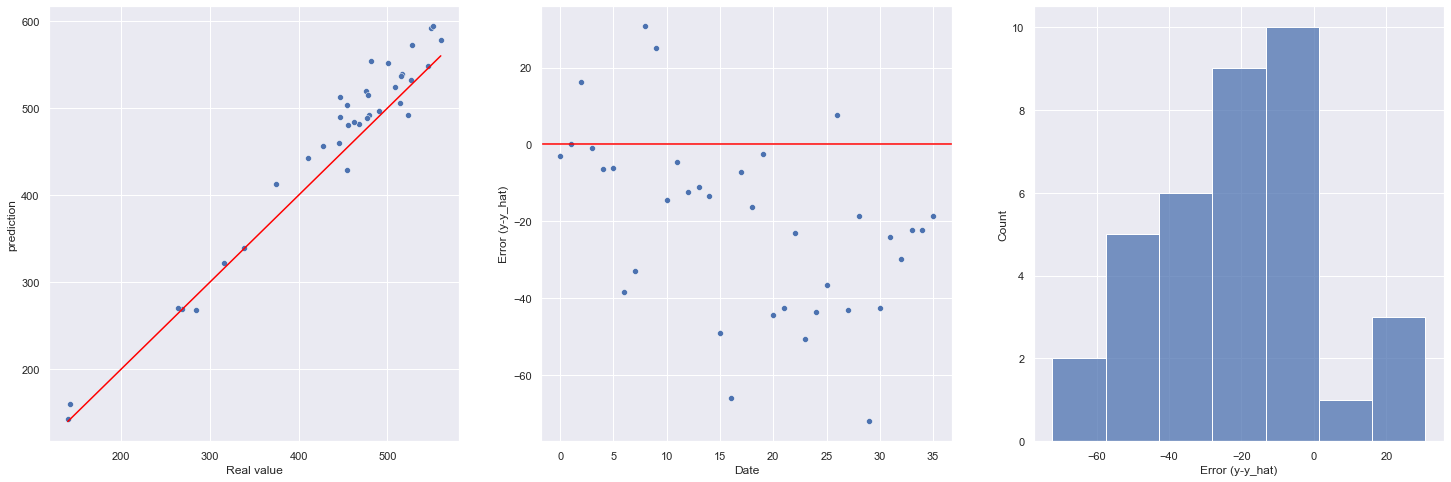

In [16]:
plot_diagnostics(res_weekly)

From the figures above, we again see that our predictions are quite close to the actual values, though not perfectly accurate.   
The figure on the right shows the bias of predictions being slightly higher than the actual values.   
Overall, our prediction algorithm produces good results with the given dataset.  
The next steps for this project would be to benchmark this model against some automatical ARIMA method,   
which would be fitted only on the final reservation time series (as previously mentioned, we dont want to have multiple models for all the curves).   
Methods like FbProphet, pmdarima or Nixtla could be used.